In [4]:
import matplotlib
matplotlib.use("TkAgg")
%pylab inline
plt.xkcd();

import scipy.signal
from PIL import Image

import plotFunks as pF

from scipy.io import wavfile
from IPython.display import Audio

Populating the interactive namespace from numpy and matplotlib


# Preamble

### Plotting Functions

In [5]:
def plotProcess(processes,names,steps,xBounds,yBounds):
    """Takes in a pair of processes and plots them,
    one as a continuous variable, the other as a binary variable"""
    plt.figure(figsize(12,4),dpi=300)
    
    ax = plt.subplot(211); pF.cleanPlot(ax);
    plt.title(names[0],weight='bold',size='large')
    pF.setLims(ax,xBounds,yBounds)
    plt.plot(steps,processes[0],color='b',marker='.')
    pF.addAxis(plt.gca()); 
    
    ax = plt.subplot(212); pF.cleanPlot(ax);
    plt.title(names[1],weight='bold',size='large')
    pF.setLims(ax,xBounds,yBounds)
    posIdx,procPos = getPos(processes[1]); 
    negIdx,procNeg = getNeg(processes[1]); 
    plt.scatter(posIdx,procPos[posIdx],color='g',marker='^',linewidths=2)
    plt.scatter(negIdx,-1*procNeg[negIdx],color='r',marker='v',linewidths=2)
    pF.addAxis(plt.gca());
    
def correlationPlots(processes,names,title):
    plt.figure()
    for idx,(process,name) in enumerate(zip(processes,names)):
        plt.subplot(2,1,idx+1); 
        plt.plot(process); 
        pF.cleanPlot(plt.gca()); pF.addAxis(plt.gca()); 
        plt.ylabel(name,rotation='horizontal',weight='bold')
    plt.suptitle(title,size=24,weight='bold',y=1.2);
    
    plt.figure(figsize=(8,8))
    lim = max([max(processes[0]),max(processes[1])]); lims = [-lim,lim]
    plt.scatter(processes[0],processes[1]); plt.xlim(lims); plt.ylim(lims);
    plt.xlabel(names[0],rotation='horizontal',weight='bold')
    plt.ylabel(names[1],rotation='horizontal',weight='bold')
    
    plt.figtext(0.33,0,"R^2 = "+str(np.corrcoef(processes[0],processes[1])[0,1]**2)) 

### Processes

In [6]:
def randomWalk(tMax=1,sigma=1,eps=0.1):
    """Constructs a random walk by iteratively adding gaussians"""
    signal=[0]; scaleFactor = np.sqrt(eps)
    for t in np.arange(0,tMax,eps):
        signal.append(signal[-1]+np.random.normal(0,sigma*scaleFactor))
    return np.asarray(signal[1:])
    
def iidNormal(tMax=1,sigma=1,eps=0.01):
    """Independent and identically distributed normals,
    with the same parameters as those in randomWalk"""
    length = tMax/eps
    return np.random.normal(0,sigma,(length,))

# Functions below turn a continuous real variable into a binary variable
def getPos(array):
    pos = np.greater(array,0)
    idxs = np.nonzero(pos)
    return idxs,pos

def getNeg(array):
    neg = np.less(array,0)
    idxs = np.nonzero(neg)
    return idxs,neg

# Correlation: What It Is And What It Isn't

Correlation famously, does not imply causation. Apart from that, causation does not imply correlation either. That is to say, just because the correlation between two variables is low, that does not mean that there is no relationship between the two variables.

So what does correlation mean? Roughly speaking, it means that when one variable is away from its mean, the other is also away from its mean. If the correlation is positive, then the variables are away from their mean in the same direction. If the correlation is negative, thenthe variables are away from their mean in opposite directions.

That's all. Correlations turn out to be a very useful first pass at understanding random variables, in particular because they are easy to compute, and they capture the simplest way two variables can be related.

In the following, we'll take a look at several groups of random variables to try and get a sense for what correlation means and what it doesn't.

In [7]:
sigma=1; tMax=1
X = iidNormal(sigma=sigma,tMax=tMax);

In the following, $X$ will always stand for a very simple random variable: at every time $t$, $X_t$ will be distributed on a bell curve -- a Normal or Gaussian distribution.

In the first segment below, we take a look at two correlated processes. $W_t$ is defined as $X_t+\epsilon$, where $\epsilon$ is another, slightly skinnier Normal distribution.

First, I show a graph of $X$ and $W$ over time. Then I plot the same data in a scatterplot. Some relationships are more obvious in one form or another. Always look at your data in multiple ways!

At the bottom of the scatterplot, I've included the $R^2$ value, which is a common method for reporting correlations -- its just the correlation squared. When this value is large, the correlation is far away from $0$. Note the cases where it captures the relationship between the variables and the cases where it does not.

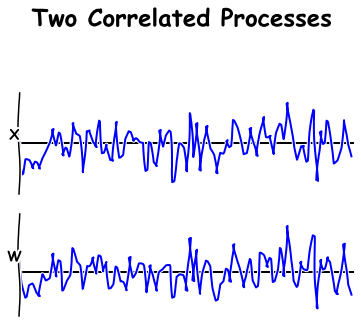

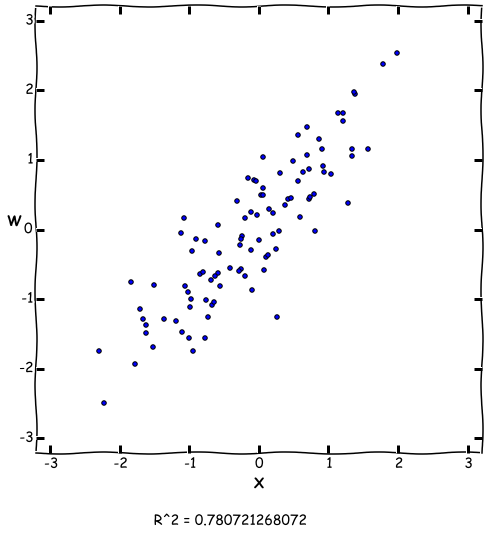

In [8]:
W = [x+np.random.normal(0,0.5) for x in X] 
#W = X + noise
correlationPlots([X,W],['X','W'],"Two Correlated Processes")

Now, we define a new random variable $Z$. $Z$ is defined the same way as $X$: independent draws from the Normal distribution at each time step. This means that the values of $Z$ and $X$ are totally unrelated.

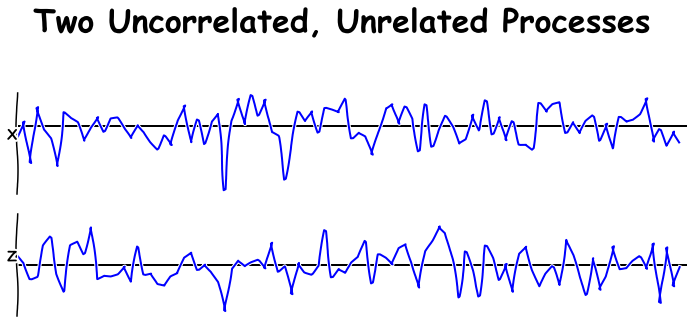

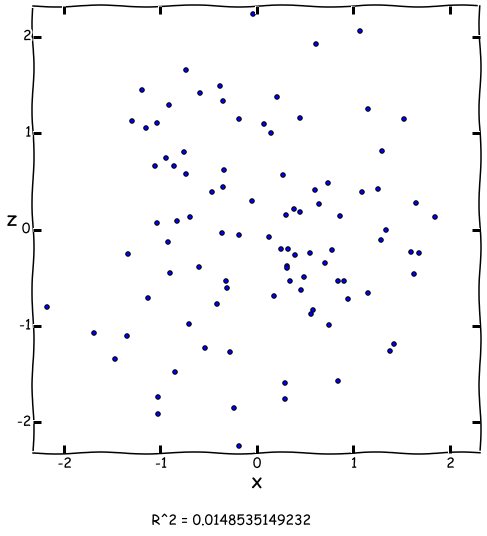

In [96]:
Z = iidNormal(sigma=sigma,tMax=tMax); #Z is just another random variable
correlationPlots([X,Z],['X','Z'],"Two Uncorrelated, Unrelated Processes")

Now we define a random variable $Y$ so that the correlation doesn't tell us anything about the relationship.
Half of the time, $Y$ is just equal to $X$ plus noise, just like $W$ was above. The other half of the time, $Y$ is equal to $-1*X$. Notice that the correlation is close to $0$! Thinking back to our definition, can you figure out why this is?

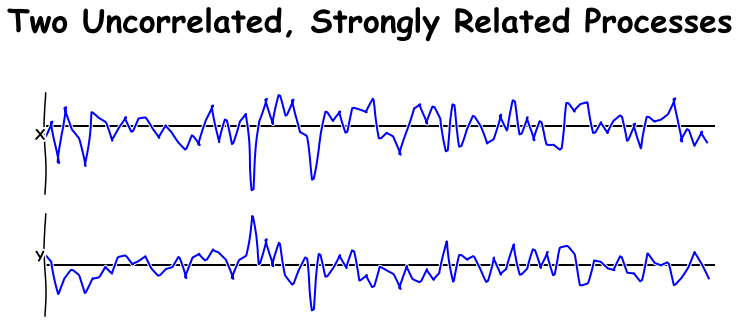

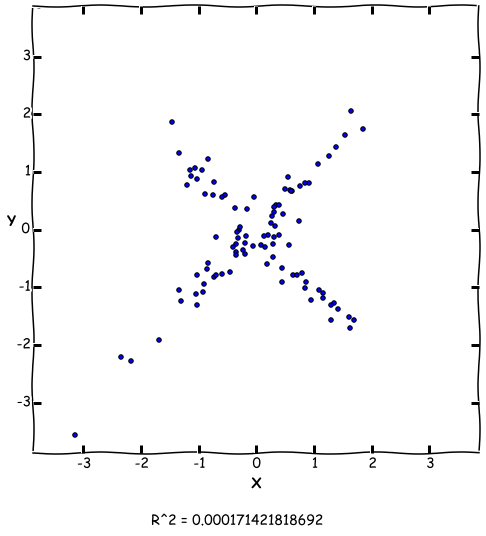

In [97]:
Y = [(-1)**(1+np.round(flip))*x+np.random.normal(0,0.2) for x,flip in zip(X,np.random.uniform(size=len(X)))]
#Y is sometimes equal to X+noise, sometimes equal to -X + noise
correlationPlots([X,Y],['X','Y'],"Two Uncorrelated, Strongly Related Processes")

Now for a slightly more realistic example: $V_t$ is equal to $X_{t-1}+\epsilon$. If we just look at the values of $X$ and $V$ at the same moment in time, it appears that $X$ and $V$ are totally unrelated. But if we look at the correlation between $V$ and _time-shifted_ version of $X$, then we see the correlation. Examples like this are the motivation for considering _time-lagged correlation_, in particular the time-lagged correlation of a variable with itself: the _auto-correlation_.

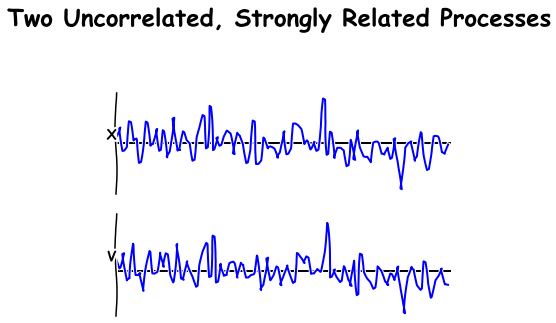

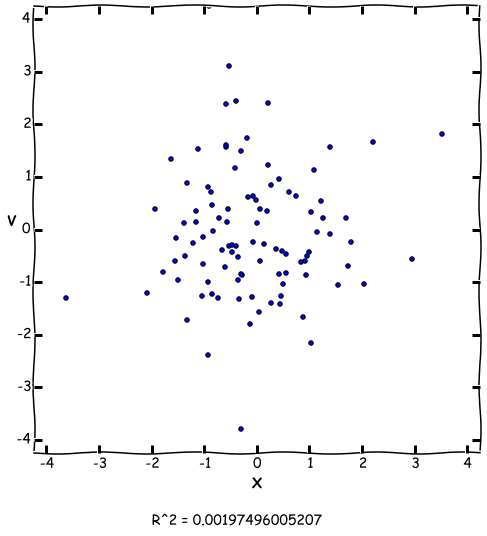

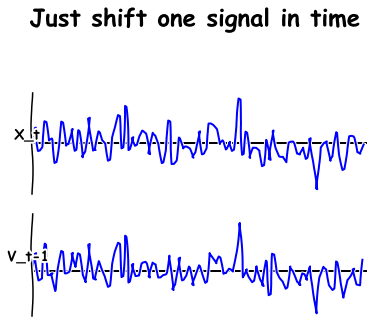

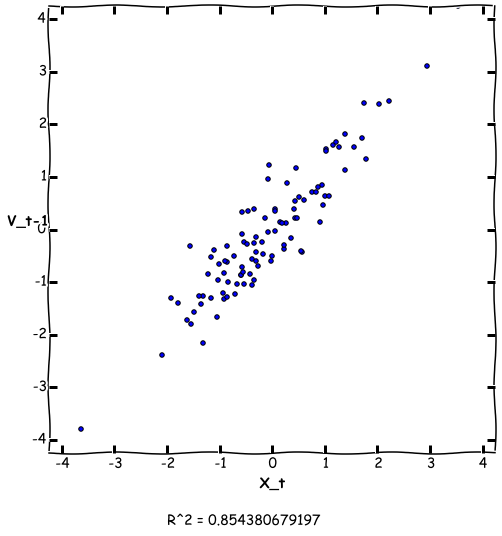

In [16]:
V = np.roll(X,1)+np.random.normal(0,0.5,size=X.shape)
#V is equal to the last time step of X, plus some noise.
correlationPlots([X,V],['X','V'],"Two Uncorrelated, Strongly Related Processes")
correlationPlots([X,np.roll(V,-1)],['X_t-1','V_t'],"Just shift one signal in time")

# Auto-Correlation: Correlation in Time

Many interesting things don't behave like the variable $X$ above. Usually, the value of a variable at some point in time depends on the previous value.

The simplest way for two variables to be related is for them to be correlated, and the kind of random variable that is described entirely by its correlations is a Gaussian random variable. If we combine those two ideas together, so that we have a Gaussian random variable that is correlated with itself in time, we get a _Random Walk_. Random walks in continuous time are fabulously complicated to analyze mathematically (they are, in fact, a form of fractal!) but they're easy to simulate and easy to describe with basic statistics.

We simulate a random walk by defining $X_{t+1} = X_{t}+\epsilon$. If we look at the raw values, we get something that behaves a little bit like the NASDAQ stock exchange. If we split the values into positive and negative results, we get something that looks kind of like the weather in Berkeley: it's rainy for a while, then sunny again for a bit, then there are periods where the weather changes frequently.

For reference, I've also plotted a process without correlations or statistical dependencies of any kind. This is a decent model for the noise that affects electrical equipment. If we do the same thresholding that got us the Berkeley weather example, we get something that just looks like a bunch of coin flips.

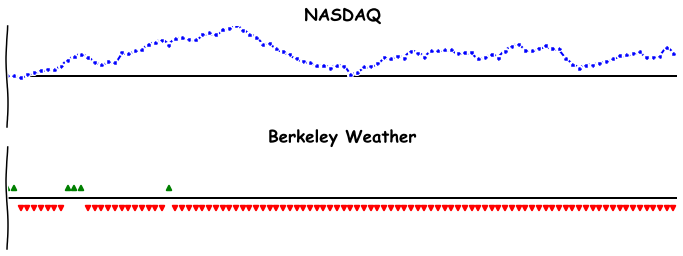

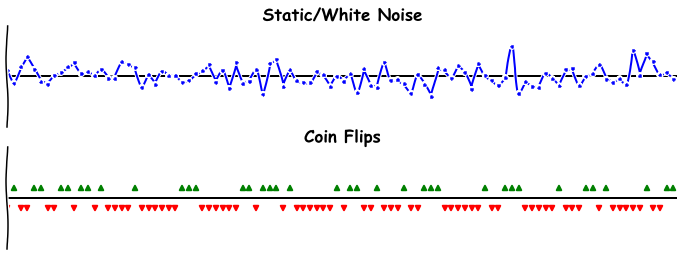

In [9]:
eps = 0.1 #stepSize
tMax = 10 #total time to simulate
sigma = 1 #magnitude of randomness

#stocks and weather: two auto-correlated processes
stocks = randomWalk(sigma=sigma,eps=eps,tMax=tMax)
weather = randomWalk(sigma=sigma,eps=eps,tMax=tMax)

#white noise and coin flips: two un-correlated processes
noise = iidNormal(sigma=sigma,eps=eps,tMax=tMax)
coins = iidNormal(sigma=sigma,eps=eps,tMax=tMax)

#some things we need to make our plots look nice
steps = range(len(stocks)); mx = max(max(np.abs(stocks)),max(np.abs(noise)))
yBounds = (-mx,mx); xBounds = (0,len(stocks)-0.5)

#now let's plot!
for processes,name in zip([(stocks,weather),(noise,coins)],
                        [['NASDAQ','Berkeley Weather'],['Static/White Noise','Coin Flips']]):
    
    plotProcess(processes,name,steps,xBounds,yBounds)

#AUTOCORRELATIONS GO HERE

## Listen to Correlations!

One convenient fact about processes with only correlation structure is that they are well-described in terms of *frequency content*. That is to say, the Fourier transform of their auto-correlation is meaningful.

For the independent normal process, the Fourier transform reveals that all frequencies are equally represented. For this reason, it is called "White Noise", by analogy with light: white light contains all (visible) frequencies.

For the random walk, values tend to stay stable for a while. This means that there is more power in the low frequencies  -- the value of a low-frequency wave changes more slowly than a high frequency wave. Since red is the lowest visible frequency, light with more low frequencies than high frequencies is reddish, and so this noise is called "red noise" or "pink noise".

You can listen to them both below!

In [12]:
time = 5 #in seconds
framerate = 44100 #in Hz
frames = time*framerate

redNoise = randomWalk(tMax=time,eps=1/framerate)
whiteNoise = iidNormal(tMax=time,eps=1/framerate)

In [13]:
# The sound of a random walk
Audio(redNoise,rate=framerate)

In [14]:
# The sound of static
Audio(whiteNoise,rate=framerate)